In [1]:
import numpy as np
import gym
from collections import deque
import random
import torch.autograd
import os
import time
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F 
from torch.autograd import Variable
import sys
import pickle
import matplotlib.pyplot as plt
import pybullet as p 
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")
import networkx as nx
from tqdm import tqdm
import dgl
import morphsim as m
from graphenvs import HalfCheetahGraphEnv
import itertools

%matplotlib notebook

Running on the GPU


Using backend: pytorch


In [2]:
class Network(nn.Module):
    def __init__(
        self,
        input_size,
        output_size,
        hidden_sizes,
        batch_size=256, # Needed only for batch norm
        with_batch_norm=False,
        activation=None
    ):
        super(Network, self).__init__()
        self.hidden_sizes = hidden_sizes
        self.input_size = input_size
        self.output_size = output_size
        
        self.layers = nn.ModuleList()

        self.layers.append(nn.Linear(self.input_size, hidden_sizes[0]))
        if with_batch_norm:
#             self.layers.append(nn.BatchNorm1d(batch_size))
            self.layers.append(nn.LayerNorm(normalized_shape=(hidden_sizes[0])))
        self.layers.append(nn.ReLU())
        
        for i in range(len(hidden_sizes) - 1):
            self.layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            if with_batch_norm:
#                 self.layers.append(nn.BatchNorm1d(batch_size))
                self.layers.append(nn.LayerNorm(normalized_shape=(hidden_sizes[i+1])))
            self.layers.append(nn.ReLU())
        
        self.layers.append(nn.Linear(hidden_sizes[len(hidden_sizes) - 1], self.output_size))
        
        if activation is not None:
            self.layers.append(activation())
            
    def forward(self, x):
        out = x
        
        for layer in self.layers:
            out = layer(out)
            
        return out

In [3]:
class GraphNeuralNetwork(nn.Module):
    def __init__(
        self,
        inputNetwork,
        messageNetwork,
        updateNetwork,
        outputNetwork,
        numMessagePassingIterations,
        encoder = True
    ):
        
        super(GraphNeuralNetwork, self).__init__()
                
        self.inputNetwork = inputNetwork
        self.messageNetwork = messageNetwork
        self.updateNetwork = updateNetwork
        self.outputNetwork = outputNetwork
        
        self.numMessagePassingIterations = numMessagePassingIterations
        self.encoder = encoder
        
    def inputFunction(self, nodes):
        return {'state' : self.inputNetwork(nodes.data['input'])}
    
    def messageFunction(self, edges):
        
        batchSize = edges.src['state'].shape[1]
        edgeData = edges.data['feature'].repeat(batchSize, 1).T.unsqueeze(-1)
        nodeInput = edges.src['input']
        
#         print(edges.src['state'].shape)
#         print(nodeInput.shape)
        return {'m' : self.messageNetwork(torch.cat((edges.src['state'], edgeData, nodeInput), -1))}
        

    def updateFunction(self, nodes):
        return {'state': self.updateNetwork(torch.cat((nodes.data['m_hat'], nodes.data['state']), -1))}
    
    def outputFunction(self, nodes):
        
#         numNodes, batchSize, stateSize = graph.ndata['state'].shape
#         return self.outputNetwork.forward(graph.ndata['state'])
        return {'output': self.outputNetwork(nodes.data['state'])}


    def forward(self, graph, state):
        
        self.update_states_in_graph(graph, state)
        
        graph.apply_nodes(self.inputFunction)
        
        for messagePassingIteration in range(self.numMessagePassingIterations):
            graph.update_all(self.messageFunction, dgl.function.max('m', 'm_hat'), self.updateFunction)
        
        graph.apply_nodes(self.outputFunction)
        
        output = graph.ndata['output']
        
        return output
    
    def update_states_in_graph(self, graph, state):
        
        if self.encoder:
            if len(state.shape) == 1:
                state = state.unsqueeze(0)

            numGraphFeature = 6
            numGlobalStateInformation = 5
            numLocalStateInformation = 2
            numStateVar = state.shape[1]
            globalInformation = state[:, 0:5]
            batch_size = state.shape[0]
            numNodes = (numStateVar - 5) // 2

            nodeData = torch.empty((numNodes, batch_size, numGraphFeature + numGlobalStateInformation + numLocalStateInformation)).to(device)

            nodeData[:, :, 0:numGlobalStateInformation] = globalInformation            
            for nodeIdx in range(numNodes):
                # Assign local state information
                nodeData[nodeIdx, :, numGlobalStateInformation] = state[:, 5 + nodeIdx]
                nodeData[nodeIdx, :, numGlobalStateInformation + 1] = state[:, 5 + numNodes + nodeIdx]
                # Assign global features from graph
                nodeData[nodeIdx, :, numGlobalStateInformation + 2 : numGlobalStateInformation + 2 + numGraphFeature] = graph.ndata['feature'][nodeIdx]

            graph.ndata['input'] = nodeData
        
        else:
            numNodes, batchSize, inputSize = state.shape
            nodeData = torch.empty((numNodes, batchSize, inputSize + 6)).to(device)
            nodeData[:, :, :inputSize] = state
            nodeData[:, :, inputSize : inputSize + 6] = graph.ndata['feature'].unsqueeze(dim=1).repeat_interleave(batchSize, dim=1)
#             for nodeIdx in range(numNodes):
#                 nodeData[nodeIdx, :, inputSize : inputSize + 6] = graph.ndata['feature'][nodeIdx]
            
            graph.ndata['input'] = nodeData
        

In [4]:
states = {}
actions = {}
rewards = {}
next_states = {}
dones = {}
env = {}

for morphIdx in range(7):

    prefix = '../datasets/{}/'.format(morphIdx)
    
    states[morphIdx] = np.load(prefix + 'states_array.npy')
    actions[morphIdx] = np.load(prefix + 'actions_array.npy')
    rewards[morphIdx] = np.load(prefix + 'rewards_array.npy')
    next_states[morphIdx] = np.load(prefix + 'next_states_array.npy')
    dones[morphIdx] = np.load(prefix + 'dones_array.npy')
    
    env[morphIdx] = HalfCheetahGraphEnv(None)
    env[morphIdx].set_morphology(morphIdx)
    env[morphIdx].reset()

/home/ovi/anaconda3/envs/honors-project/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
NoneType: None


None
*************************************************************************************************************


NoneType: None


None
*************************************************************************************************************


NoneType: None


None
*************************************************************************************************************


NoneType: None


None
*************************************************************************************************************


NoneType: None


None
*************************************************************************************************************


NoneType: None


None
*************************************************************************************************************
None
*************************************************************************************************************


NoneType: None


In [5]:
hidden_sizes = [256, 256]

inputSize = 13
stateSize = 64
messageSize = 64
latentSize = 2
numMessagePassingIterations = 4
batch_size = 1024
numBatchesPerTrainingStep = 1
minRandomDistance = 1
maxSequentialDistance = 0.04
with_batch_norm = True

# # Encoder Networks
encoderInputNetwork = Network(inputSize, stateSize, hidden_sizes, with_batch_norm=with_batch_norm)
encoderMessageNetwork = Network(stateSize + inputSize + 1, messageSize, hidden_sizes, with_batch_norm=with_batch_norm, activation=nn.Tanh)
encoderUpdateNetwork = Network(stateSize + messageSize, stateSize, hidden_sizes, with_batch_norm=with_batch_norm)
encoderOutputNetwork = Network(stateSize, latentSize, hidden_sizes, with_batch_norm=with_batch_norm, activation=nn.Tanh)
encoderGNN = GraphNeuralNetwork(encoderInputNetwork, encoderMessageNetwork, encoderUpdateNetwork, encoderOutputNetwork, numMessagePassingIterations, encoder=True).to(device)

# # Decoder Networks
decoderInputNetwork = Network(latentSize + 6, stateSize, hidden_sizes, with_batch_norm=with_batch_norm)
decoderMessageNetwork = Network(stateSize + latentSize + 7, messageSize, hidden_sizes, with_batch_norm=with_batch_norm, activation=nn.Tanh)
decoderUpdateNetwork = Network(stateSize + messageSize, stateSize, hidden_sizes, with_batch_norm=with_batch_norm)
decoderOutputNetwork = Network(stateSize, 7, hidden_sizes, with_batch_norm=with_batch_norm)
decoderGNN = GraphNeuralNetwork(decoderInputNetwork, decoderMessageNetwork, decoderUpdateNetwork, decoderOutputNetwork, numMessagePassingIterations, encoder=False).to(device)


encoderGNN.load_state_dict(torch.load('encoderGNN-normalized-time-contrastive.pt'))
decoderGNN.load_state_dict(torch.load('decoderGNN-normalized-time-contrastive.pt'))

# Optimizer
lr =  1e-5
optimizer = optim.Adam(itertools.chain(
                    encoderInputNetwork.parameters(), encoderMessageNetwork.parameters(), 
                    encoderUpdateNetwork.parameters(), encoderOutputNetwork.parameters(),
                    decoderInputNetwork.parameters(), decoderMessageNetwork.parameters(), 
                    decoderUpdateNetwork.parameters(), decoderOutputNetwork.parameters()),
                    lr, weight_decay=0)

lr_lambda = lambda epoch: 0.7
lr_scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda)
criterion  = nn.MSELoss(reduction='none')

<IPython.core.display.Javascript object>


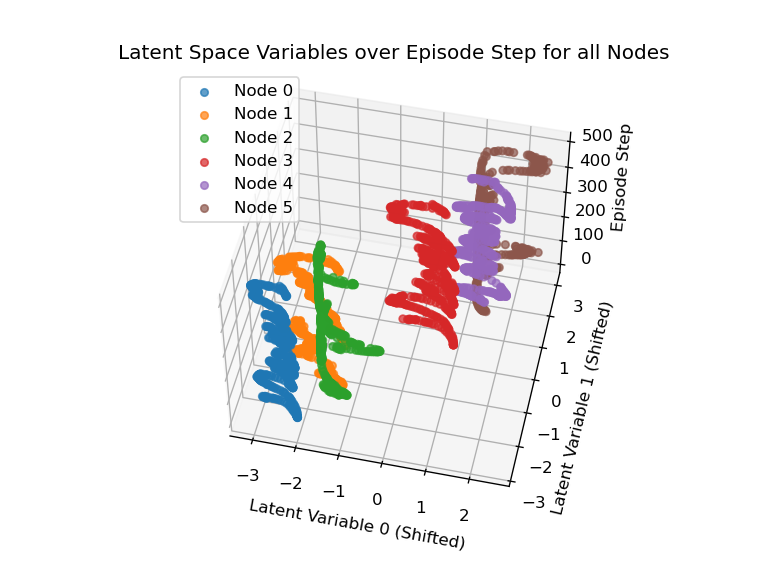

In [6]:
shiftAmount = 1


for morphIdx in range(1):
    
    with torch.no_grad():
        
        numEpisodesToAverage = 1
        normalized_latent_states = None
        for episodeNumber in range(numEpisodesToAverage):
            
            g = env[morphIdx].get_graph()._get_dgl_graph().to(device)
            if normalized_latent_states is None:
                latentEncodings = encoderGNN(g, torch.from_numpy(states[morphIdx][500 * numEpisodesToAverage: 500 * (numEpisodesToAverage+1)])) / numEpisodesToAverage
                normalized_latent_states = latentEncodings / torch.sqrt((latentEncodings ** 2).sum(dim=1)).unsqueeze(1)

            else:
                latentEncodings = encoderGNN(g, torch.from_numpy(states[morphIdx][500 * numEpisodesToAverage: 500 * (numEpisodesToAverage+1)])) / numEpisodesToAverage
                normalized_latent_states += latentEncodings / torch.sqrt((latentEncodings ** 2).sum(dim=1)).unsqueeze(1)

    
    latentEncodings = latentEncodings.to('cpu')
    numNodes, batchSize, latentSize = latentEncodings.shape
    fig = plt.figure() 
    z = np.arange(batchSize) 
    # syntax for 3-D projection 
    ax = plt.axes(projection ='3d') 

    
    for nodeIdx in range(numNodes):
        
        xy_shift = (- numNodes / 2 + nodeIdx) * shiftAmount
        # defining all 3 axes 
        x = np.array(latentEncodings[nodeIdx, :, 0]) + xy_shift
        y = np.array(latentEncodings[nodeIdx, :, 1]) + xy_shift

        # plotting 
        ax.scatter3D(x, y, z, alpha=0.7)
    ax.set_xlabel('Latent Variable 0 (Shifted)')
    ax.set_ylabel('Latent Variable 1 (Shifted)')
    ax.set_zlabel('Episode Step')
    ax.set_title('Latent Space Variables over Episode Step for all Nodes')
    ax.legend(['Node ' + str(x) for x in range(numNodes)])

    ax.view_init(elev=0, azim=45)
    fig.savefig('{}-latentVis-1.png'.format(morphIdx))

    ax.view_init(elev=30, azim=90)
    fig.savefig('{}-latentVis-2.png'.format(morphIdx))
    
    
    ax.view_init(elev=15, azim=0)
    fig.savefig('{}-latentVis-3.png'.format(morphIdx))

    ax.view_init(elev=90, azim=0)
    fig.savefig('{}-latentVis-4.png'.format(morphIdx))

    plt.show() 